<a href="https://colab.research.google.com/github/JoelBenesh/marked-beetle-analysis-1/blob/main/EfficientNetB0_with_original_images_from_MarkedBeetleImageAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
filenames = os.listdir("/content/drive/MyDrive/MarkedBeetleImageAnalysis")
filenames[:4]

['PaperedControl20d.tif',
 'PaperedControl20d_light.tif',
 'PaperedControl21v.tif',
 'PaperedControl21v_light.tif']

In [4]:
train_images=[]
for filename in filenames:
    if 'light' not in filename:
      if filename.startswith('Papered') or filename.startswith('NoPapered'):
        train_images.append(filename)
print(f"Number of Train images: {len(train_images)}") #filename.startswith('Pink')

Number of Train images: 757


In [5]:
test_images=[]
for filename in filenames:
    if filename.startswith('Trap'):
        test_images.append(filename)
print(f"Number of Test images: {len(test_images)}")

Number of Test images: 77


In [6]:
categories = []
for filename in train_images:
    if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('marked')
    if filename.startswith('NoPapered'):
        categories.append('unmarked')
len(categories)

757

In [7]:
df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
df

,filename,category
0,PaperedControl20d.tif,marked
1,PaperedControl21v.tif,marked
2,PaperedControl21d.tif,marked
3,PaperedControl22v.tif,marked
4,PaperedControl22d.tif,marked
...,...,...
752,PaperedControl18v.tif,marked
753,PaperedControl18d.tif,marked
754,PaperedControl19v.tif,marked
755,PaperedControl19d.tif,marked


In [8]:
df['category'].value_counts()

marked      479
unmarked    278
Name: category, dtype: int64

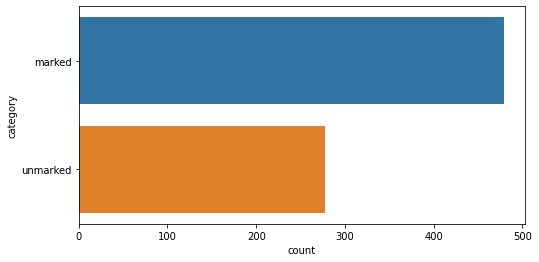

In [9]:
plt.figure(figsize=(8, 4))
sns.countplot(y="category", data=df);

In [10]:
image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", filenames[0]))
image.shape

(1944, 2592, 3)

In [11]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind+1 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [12]:
tmp_df = df.sample(9)
tmp_df

,filename,category
555,NoPaperedMixed34d.tif,unmarked
312,PaperedTransparent97v.tif,marked
535,NoPaperedMixed24d.tif,unmarked
2,PaperedControl21d.tif,marked
112,PaperedControl76v.tif,marked
160,PaperedTransparent21v.tif,marked
639,PaperedMixed26d.tif,marked
287,PaperedTransparent84d.tif,marked
175,PaperedTransparent28d.tif,marked


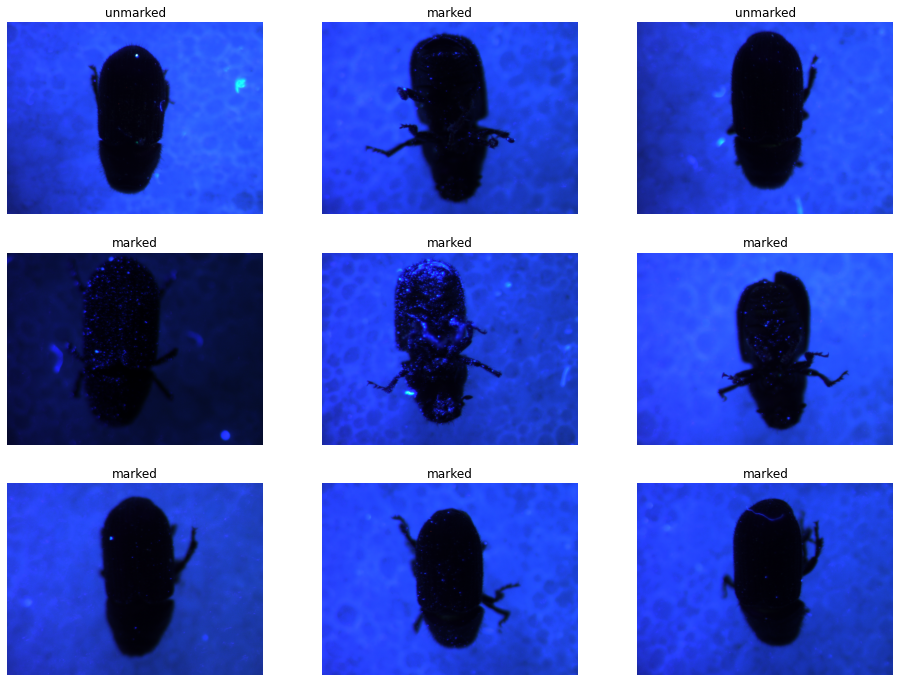

In [13]:
image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)

In [14]:
#df["category"] = df["category"].replace({0: 'NotMarked', 1: 'Marked'}) 

In [15]:
train_df, validate_df = train_test_split(df, test_size = 0.20, random_state = 42, stratify = df['category'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

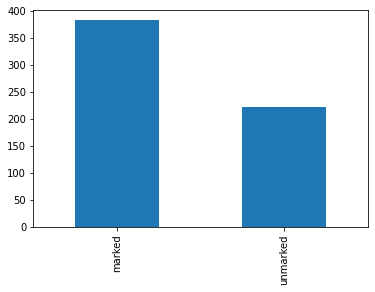

In [16]:
train_df['category'].value_counts().plot.bar()

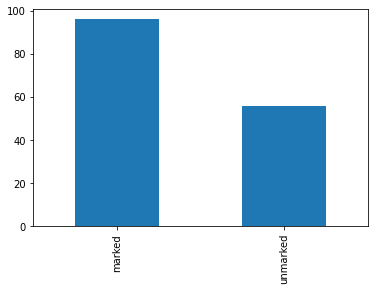

In [17]:
validate_df['category'].value_counts().plot.bar()

In [18]:
IMG_SIZE = 224
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 5
BATCH_SIZE = 50

In [19]:
datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    #channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

In [20]:
datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

In [21]:
train_set = datagen_train.flow_from_dataframe(train_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 605 validated image filenames belonging to 2 classes.


In [22]:
validate_set = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 152 validated image filenames belonging to 2 classes.


In [23]:
from tensorflow.keras import layers
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [24]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import  Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
def create_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
    #model = EfficientNetB7(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False,
                            # weights = 'imagenet',
                             #drop_connect_rate=0.6)
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001))(x)

    top_dropout_rate = 0.5
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(2, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    return model

model = create_model()
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [25]:
EPOCHS = 50
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = validate_set.n//validate_set.batch_size

In [26]:
def Model_fit():
    
    model = create_model()
    '''Compiling the model'''
    #unfreeze_model(model)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['accuracy']) #'acc'
    
        # Stop training when the val_loss has stopped decreasing for 3 epochs.
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("B0_original_images_model.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    history = model.fit(train_set,
                             validation_data = validate_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[stop, checkpoint_cb, reduce_lr])
    model.save('model'+'.h5')  
    return history

In [27]:
results = Model_fit()

Epoch 1/50
12/12 [==============================] - 728s 61s/step - loss: 0.7478 - accuracy: 0.7225 - val_loss: 0.4913 - val_accuracy: 0.7400


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
12/12 [==============================] - 335s 29s/step - loss: 0.5237 - accuracy: 0.8162 - val_loss: 0.4508 - val_accuracy: 0.8133
Epoch 3/50
12/12 [==============================] - 316s 27s/step - loss: 0.5132 - accuracy: 0.8054 - val_loss: 0.4067 - val_accuracy: 0.7933
Epoch 4/50
12/12 [==============================] - 320s 27s/step - loss: 0.5737 - accuracy: 0.8090 - val_loss: 0.3866 - val_accuracy: 0.8133
Epoch 5/50
12/12 [==============================] - 305s 26s/step - loss: 0.5828 - accuracy: 0.7910 - val_loss: 0.3593 - val_accuracy: 0.8467
Epoch 6/50
12/12 [==============================] - 316s 27s/step - loss: 0.5618 - accuracy: 0.7982 - val_loss: 0.3748 - val_accuracy: 0.8267
Epoch 7/50
12/12 [==============================] - 314s 27s/step - loss: 0.4445 - accuracy: 0.8432 - val_loss: 0.3305 - val_accuracy: 0.8600
Epoch 8/50
12/12 [==============================] - 329s 28s/step - loss: 0.4200 - accuracy: 0.8396 - val_loss: 0.3586 - val_accuracy: 0.8267
Epoch 

In [28]:
print('Train_Cat-Acc: ', max(results.history['accuracy']))
print('Val_Cat-Acc: ', max(results.history['val_accuracy']))

Train_Cat-Acc:  0.8432432413101196
Val_Cat-Acc:  0.8600000143051147


In [29]:
print('Train_Cat-Loss: ', min(results.history['loss']))
print('Val_Cat-Loss: ', min(results.history['val_loss']))

Train_Cat-Loss:  0.41998761892318726
Val_Cat-Loss:  0.33047327399253845


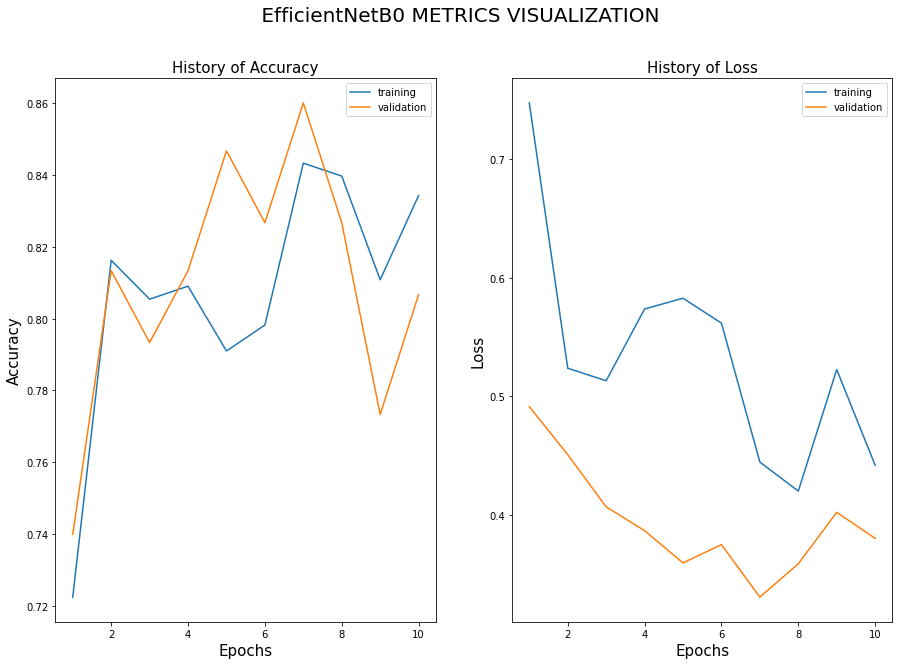

In [30]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" EfficientNetB0 METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(results.history['accuracy'],results.history['val_accuracy'],
               results.history['loss'],results.history['val_loss'])

In [31]:
final_model = keras.models.load_model("B0_original_images_model.h5")

In [32]:
tmp_df1=df.sample(10)
tmp_df1

,filename,category
586,NoPaperedMixed50v.tif,unmarked
585,NoPaperedMixed49d.tif,unmarked
400,NoPaperedGreen42v.tif,unmarked
371,NoPaperedGreen36v.tif,unmarked
523,NoPaperedMixed18d.tif,unmarked
262,PaperedTransparent72v.tif,marked
715,PaperedControl8v.tif,marked
347,NoPaperedGreen34d.tif,unmarked
549,NoPaperedMixed31d.tif,unmarked
274,PaperedTransparent78v.tif,marked


In [33]:
nb_samples = tmp_df1.shape[0]

In [34]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    brightness_range = [0.3,0.9],
                    channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')
test_generator = test_gen.flow_from_dataframe(
    tmp_df1, 
    "/content/drive/MyDrive/MarkedBeetleImageAnalysis/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 10 validated image filenames.


In [35]:
predict = final_model.predict(test_generator, steps=np.ceil(nb_samples/BATCH_SIZE))

In [36]:
tmp_df1['prediction'] = np.argmax(predict, axis=-1)
tmp_df1["prediction"] = tmp_df1["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1

,filename,category,prediction
586,NoPaperedMixed50v.tif,unmarked,marked
585,NoPaperedMixed49d.tif,unmarked,marked
400,NoPaperedGreen42v.tif,unmarked,unmarked
371,NoPaperedGreen36v.tif,unmarked,marked
523,NoPaperedMixed18d.tif,unmarked,unmarked
262,PaperedTransparent72v.tif,marked,marked
715,PaperedControl8v.tif,marked,marked
347,NoPaperedGreen34d.tif,unmarked,marked
549,NoPaperedMixed31d.tif,unmarked,marked
274,PaperedTransparent78v.tif,marked,unmarked


In [37]:
to_samples = df.shape[0]

In [38]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    brightness_range = [0.3,0.9],
                    channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')
test_generator1 = test_gen.flow_from_dataframe(
    df, 
    "/content/drive/MyDrive/MarkedBeetleImageAnalysis/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 757 validated image filenames.


In [39]:
predict = final_model.predict(test_generator1, steps=np.ceil(to_samples/BATCH_SIZE))

In [40]:
predict

array([[0.9098699 , 0.38474083],
       [0.83544433, 0.3729818 ],
       [0.93298054, 0.3810561 ],
       ...,
       [0.91144997, 0.41998672],
       [0.7089212 , 0.4836955 ],
       [0.7765567 , 0.4156788 ]], dtype=float32)

In [41]:
df['prediction'] = np.argmax(predict, axis=-1)
df["prediction"] = df["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
df

,filename,category,prediction
0,PaperedControl20d.tif,marked,marked
1,PaperedControl21v.tif,marked,marked
2,PaperedControl21d.tif,marked,marked
3,PaperedControl22v.tif,marked,marked
4,PaperedControl22d.tif,marked,marked
...,...,...,...
752,PaperedControl18v.tif,marked,marked
753,PaperedControl18d.tif,marked,marked
754,PaperedControl19v.tif,marked,marked
755,PaperedControl19d.tif,marked,marked


In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(df['category'])
y_pred=list(df['prediction'])
cm=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])

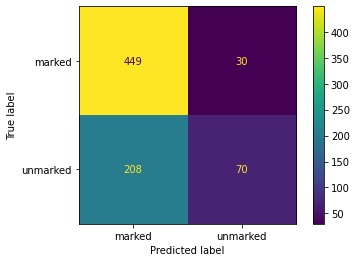

In [43]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["marked", "unmarked"])
disp.plot(values_format="d") 

In [44]:
final_modell = keras.models.load_model('best_model.h5')

OSError: ignored

In [ ]:
preds=[]
for image_id in tmp_df1.filename:
  image = Image.open(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis/",image_id))
  image = image.resize((600,600))
  image = np.expand_dims(image,axis=0)
  preds.append(np.argmax(final_modell.predict(image)))
tmp_df1["prediction1"]=preds

In [ ]:
tmp_df1["prediction1"] = tmp_df1["prediction1"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1